<a href="https://colab.research.google.com/github/ramonbdes/Projeto_Finor_FM/blob/main/Finor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @title Carregando pacotes
#ETAPA 1
!pip install gurobipy
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
import gurobipy as gp
import os

# ====================================================================
# CONFIGURAÇÃO DA LICENÇA GUROBI (MIQP)
# ====================================================================

WLSACCESSID = "<faa84afd-4018-4bb2-8dde-bd0e3703f9f0>"
WLSSECRET = "<72801a01-4b7f-4fa7-b78f-a76926847534>"
LICENSEID = 2721027
# Define as variáveis de ambiente
os.environ["GRB_WLSACCESSID"] = WLSACCESSID
os.environ["GRB_WLSSECRET"] = WLSSECRET
os.environ["GRB_LICENSEID"] = str(LICENSEID)

# Configuração de plotagem
sns.set_style("whitegrid")
# Parâmetro global K (número máximo de ativos)
K_ATUAL = 5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 55.3 MB/s eta 0:00:00


In [3]:
# @title Baixando índices
"""**2. Baixar os dados dos índices. Precisamos de 7 anos de histórico."""
# Definir datas
start_date = "2017-01-01"
end_date = "2024-12-31"

# Índices
ibov = "^BVSP"
sp100 = "^OEX"

# Baixar os preços de fechamento ajustados
dados_ibov = yf.download(ibov, start=start_date, end=end_date)["Close"]
dados_sp100 = yf.download(sp100, start=start_date, end=end_date)["Close"]

# Normalização para visualização
dados_ibov_norm = dados_ibov / dados_ibov.iloc[0] * 100
dados_sp100_norm = dados_sp100 / dados_sp100.iloc[0] * 100

""" 3. Baixar os componentes do S&P100 """
# Lista de tickers do S&P100
tickers_sp100 = ["JNJ", "UNH", "PFE", "LLY",
                 "ABBV", "ABT", "AMGN", "TMO",
                 "MDT", "DHR", "BDX", "ZTS", "ISRG",
                 "GILD", "REGN"]

"""" Lista de tickers com base em ramo de negócio
tickers_sp100 = [
    # Tecnologia (Technology)
    "AAPL", "MSFT", "GOOGL", "GOOG", "AMZN", "NVDA", "META", "ADBE", "CRM",
    "INTC", "CSCO", "AVGO", "TXN", "QCOM", "AMD", "ORCL", "NOW", "INTU",

    # Financeiro (Financial)
    "JPM", "BAC", "WFC", "C", "MS", "GS", "PNC", "SPGI", "BLK", "AXP", "CB",
    "MMC", "AON",

    # Saúde (Healthcare)
    "JNJ", "UNH", "PFE", "LLY", "ABBV", "ABT", "AMGN", "TMO", "MDT", "DHR",
    "BDX", "ZTS", "ISRG", "GILD", "REGN",

    # Consumo Discricionário (Consumer Discretionary)
    "TSLA", "HD", "MCD", "NKE", "BKNG", "SBUX", "LOW", "TGT", "TJX",
    "YUM", "CMCSA", "DIS", "NFLX", "LULU",

    # Consumo Essencial (Consumer Staples)
    "WMT", "PG", "KO", "PEP", "COST", "MO", "CVS", "KHC", "CL",

    # Energia e Industrial (Energy & Industrials)
    "XOM", "CVX", "SLB", "EOG", "COP", "CAT", "BA", "MMM", "LMT",
    "HON", "UPS", "FDX", "RTX", "GE", "DE",

    # Outros (Utilities, Real Estate, Materials)
    "NEE", "DUK", "SO", "EIX", "EQIX", "PLD", "APTV", "AMT", "CCI", "MSCI",
    "ITW", "SHW"
]
"""

# Baixar dados de preços (dados_acoes)
dados_acoes = yf.download(tickers_sp100, start=start_date, end=end_date)["Close"]

"""
**4. Tratar os dados**
Preenchimento de falhas e alinhamento de datas.
"""
# Preenchimento de NaNs com o valor anterior e remoção de linhas restantes
dados_acoes = dados_acoes.ffill().dropna(axis=0)
dados_sp100 = dados_sp100.ffill().dropna(axis=0)

# Remover colunas com mais de 10% de valores nulos (Se existirem)
dados_acoes = dados_acoes.dropna(axis=1, thresh=int(0.9 * len(dados_acoes)))

"""
**5. Calcular retornos**
"""
# Retornos logarítmicos
retornos = np.log(dados_acoes / dados_acoes.shift(1)).dropna()
retorno_indice = np.log(dados_sp100 / dados_sp100.shift(1)).dropna()

print(f"\nTotal de ativos após tratamento: {retornos.shape[1]}")
print(f"Total de períodos (dias de negociação): {retornos.shape[0]}")



/tmp/ipython-input-3582060476.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados_ibov = yf.download(ibov, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3582060476.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados_sp100 = yf.download(sp100, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3582060476.py:58: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados_acoes = yf.download(tickers_sp100, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  15 of 15 completed


Total de ativos após tratamento: 15
Total de períodos (dias de negociação): 2010


Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.05

Optimize a model with 17 rows, 30 columns and 60 nonzeros
Model fingerprint: 0x7a24c917
Model has 120 quadratic objective terms
Variable types: 15 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-01, 7e-01]
  QObjective range [6e-01, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 0.4171753
Presolve time: 0.00s
Presolved: 33 rows, 38 columns, 92 nonzeros
Presolved model has 128 quadratic objective terms
Variable types: 23 continuous, 15 integer (15 binary)

Root relaxation: objective 9.546814e-02, 64 iter

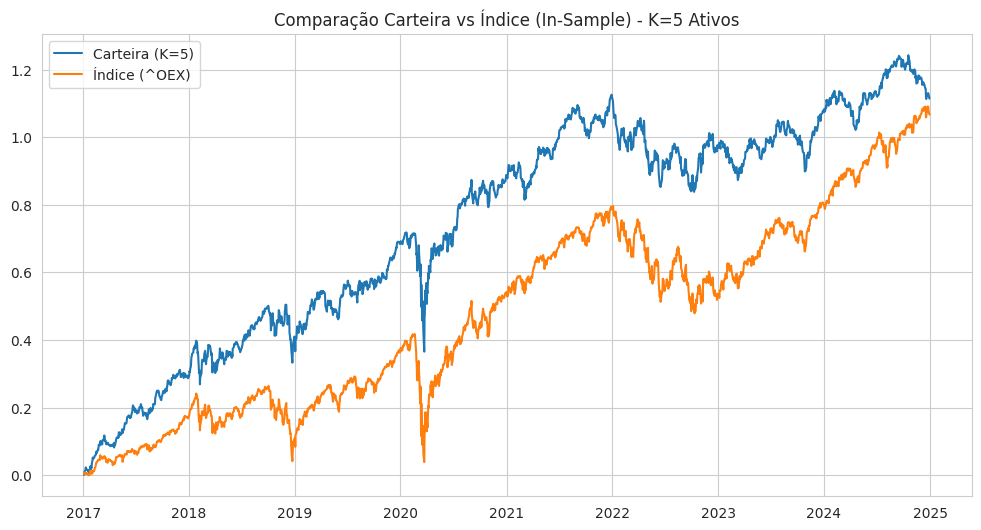

Tracking Error (In-Sample): 0.506923

--- ATIVOS SELECIONADOS NA CARTEIRA ---
Total de ativos selecionados (K=5): 5
| Ticker   |   Peso |
|:---------|-------:|
| JNJ      | 0.2508 |
| ISRG     | 0.2246 |
| ZTS      | 0.1798 |
| DHR      | 0.1743 |
| AMGN     | 0.1704 |


In [ ]:
# @title S&P100 1
"""6. Montar o modelo de otimização (GUROBI - MIQP) """
import gurobipy as gp

n = retornos.shape[1]
T = retornos.shape[0]

# ====================================================================
# 1. PREPARAÇÃO DE DADOS PARA GUROBI
# ====================================================================

# Calcule a Matriz de Covariância
Retornos_DF = retornos.copy()
Retornos_DF['Index'] = retorno_indice
Matriz_Cov = Retornos_DF.cov() * T

Cov_Acoes = Matriz_Cov.iloc[:-1, :-1].values # Matriz N x N
Cov_Index = Matriz_Cov.iloc[-1, :-1].values  # Vetor 1 x N
Var_Index = Matriz_Cov.iloc[-1, -1]          # Escalar

# Constante Big M
BIG_M = 1.0 # O peso máximo de um ativo, já que sum(w) = 1

# ====================================================================
# 2. MODELAGEM GUROBI DIRETA
# ====================================================================

modelo = gp.Model("Index_Tracking_MIQP")

# Variáveis (w: contínua >= 0; z: binária)
w_gurobi = modelo.addVars(n, name="w", lb=0.0)
z_gurobi = modelo.addVars(n, name="z", vtype=gp.GRB.BINARY)

# Restrições
# 1. Soma dos pesos = 1
modelo.addConstr(w_gurobi.sum() == 1, name="Soma_Pesos")

# 2. Restrição K: Força EXATAMENTE K ativos (substitui o '<=' por '==')
modelo.addConstr(z_gurobi.sum() == K_ATUAL, name="Restricao_K")

# 3. Vínculo Binário (w_i <= M * z_i) - CORREÇÃO DE LIGAÇÃO
# Garante que w[i] > 0 SÓ SE z[i] = 1 (ativo selecionado)
modelo.addConstrs((w_gurobi[i] <= BIG_M * z_gurobi[i] for i in range(n)), name="Vinculo_Binario")

# Função Objetivo (Minimizar a Variância do Tracking Error)
termo_quadratico = gp.QuadExpr()
for i in range(n):
    for j in range(n):
        termo_quadratico.addTerms(Cov_Acoes[i, j], w_gurobi[i], w_gurobi[j])

termo_linear = gp.LinExpr()
for i in range(n):
    termo_linear.addTerms(-2 * Cov_Index[i], w_gurobi[i])

modelo.setObjective(termo_quadratico + termo_linear + Var_Index, gp.GRB.MINIMIZE)

# 3. Otimizar


modelo.Params.MIPGap = 0.05  # Para aceitar um Gap de X%
modelo.Params.TimeLimit = 600 # Limite de tempo de 10 minutos (600 segundos)

modelo.optimize()
modelo.Params.OutputFlag = 1
print(f"\nIniciando otimização direta com Gurobi (MIQP) com K={K_ATUAL}...")
modelo.optimize()

# ====================================================================
# 4. TRATAMENTO DE RESULTADOS
# ====================================================================
pesos = np.zeros(n)
if modelo.status == gp.GRB.OPTIMAL:
    print("Otimização Direta com Gurobi concluída com sucesso!")
    # Extrai os pesos otimizados
    pesos = np.array([w_gurobi[i].X for i in range(n)])

    # Valida o número de ativos selecionados
    ativos_selecionados_count = np.sum(pesos > 1e-4)
    print(f"Ativos selecionados (contagem): {ativos_selecionados_count}")

elif modelo.status == gp.GRB.INFEASIBLE:
    print("Otimização Falhou: Modelo Inviável. Tente aumentar K ou revisar as restrições.")

else:
    print(f"Otimização Falhou. Status Gurobi: {modelo.status}")


"""
**7. Validar a carteira (In-Sample)**
"""
# Otimização funcionou: prosseguir com a validação
carteira = (retornos @ pesos).cumsum()
indice = retorno_indice.cumsum()

plt.figure(figsize=(12, 6))
plt.plot(carteira, label=f"Carteira (K={K_ATUAL})")
plt.plot(indice, label="Índice (^OEX)")
plt.legend()
plt.title(f"Comparação Carteira vs Índice (In-Sample) - K={K_ATUAL} Ativos")
plt.show()

# Tracking Error In-Sample
te_in_sample = np.sqrt(np.mean((carteira.values - indice.values)**2))
print(f"Tracking Error (In-Sample): {te_in_sample:.6f}")


# 1. Cria um DataFrame com os resultados
pesos_df = pd.DataFrame(
    {'Peso': pesos},
    index=retornos.columns # O índice dos pesos deve ser o nome das colunas de 'retornos'
)

# 2. Filtrar os ativos que realmente entraram na carteira (Peso > 0)
# Usamos um limiar pequeno (e.g., 1e-4) para excluir pesos muito próximos de zero devido a erros de ponto flutuante.
ativos_selecionados = pesos_df[pesos_df['Peso'] > 1e-4]

# 3. Ordenar e Exibir
ativos_selecionados = ativos_selecionados.sort_values(by='Peso', ascending=False)

print("\n--- ATIVOS SELECIONADOS NA CARTEIRA ---")
print(f"Total de ativos selecionados (K={K_ATUAL}): {len(ativos_selecionados)}")
print(ativos_selecionados.to_markdown(floatfmt=".4f"))

/tmp/ipython-input-3016109383.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados_sp100 = yf.download(sp100, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3016109383.py:37: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados_acoes = yf.download(tickers_sp100, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  15 of 15 completed


Dados carregados: 2010 dias, 15 ativos.

Total de dias disponíveis: 2010
Usando 756 dias para treino e 252 dias para teste.
Iniciando backtesting com janela deslizante...


Fold 1: treino [0:756] | teste [756:1008]

Ações escolhidas pelo modelo:
         Peso (%)
Ticker           
JNJ     24.130319
PFE     23.153717
ISRG    18.499486
ZTS     18.277128
UNH     15.939350


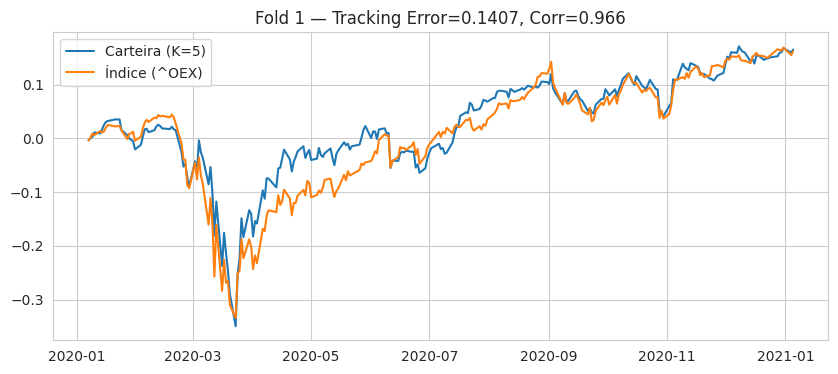


Fold 2: treino [252:1008] | teste [1008:1260]

Ações escolhidas pelo modelo:
         Peso (%)
Ticker           
JNJ     23.751306
ZTS     20.550669
AMGN    19.477955
MDT     18.119346
ISRG    18.100723


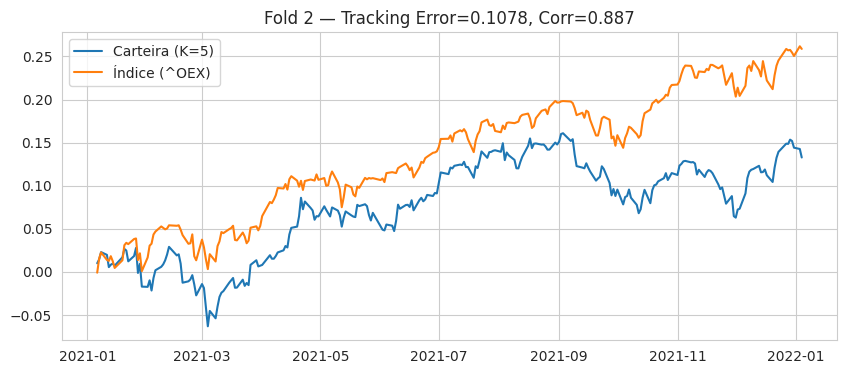


Fold 3: treino [504:1260] | teste [1260:1512]

Ações escolhidas pelo modelo:
         Peso (%)
Ticker           
JNJ     25.630984
ZTS     20.318304
ISRG    19.402691
AMGN    18.135729
MDT     16.512292


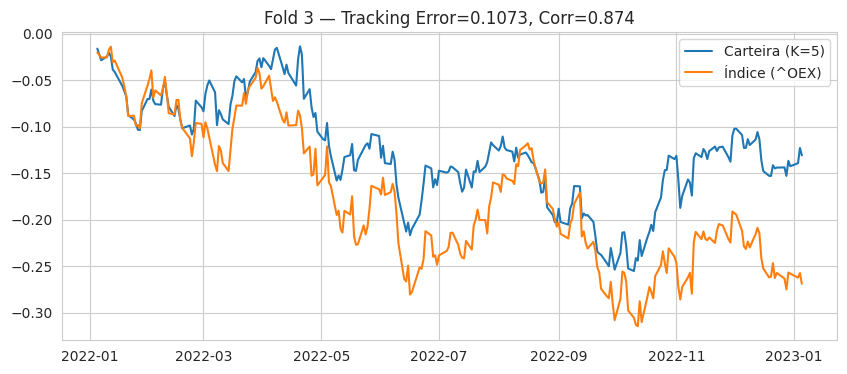


Fold 4: treino [756:1512] | teste [1512:1764]

Ações escolhidas pelo modelo:
         Peso (%)
Ticker           
ISRG    23.927505
JNJ     22.595371
ZTS     20.100971
AMGN    18.105316
DHR     15.270837


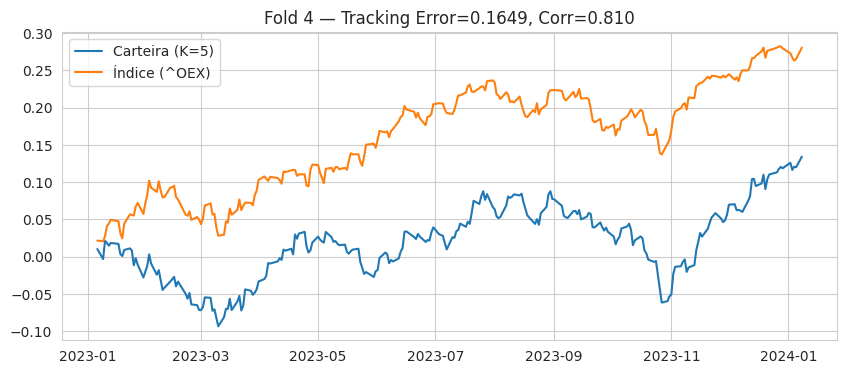


📈 Resultados finais:
   Fold  TrackingError  Correlação
0     1       0.140681    0.966258
1     2       0.107781    0.887008
2     3       0.107318    0.873739
3     4       0.164853    0.810241

📉 Média TE: 0.130158 | Média Corr: 0.8843


In [ ]:
#@title S&100_2: Backtesting


# ============================================================
# 1. Importações e Configuração Inicial
# ============================================================
%matplotlib inline

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gurobipy as gp
import os

sns.set_style("whitegrid")

# ============================================================
# 2. Parâmetros Gerais
# ============================================================
K_ATUAL = 5  # número máximo de ativos
start_date = "2017-01-01"
end_date = "2024-12-31"
sp100 = "^OEX"  # S&P100

# ============================================================
# 3. Baixar Dados
# ============================================================
tickers_sp100 = [
    "JNJ", "UNH", "PFE", "LLY", "ABBV", "ABT", "AMGN",
    "TMO", "MDT", "DHR", "BDX", "ZTS", "ISRG", "GILD", "REGN"
]

# Baixar os preços de fechamento ajustados
dados_sp100 = yf.download(sp100, start=start_date, end=end_date)["Close"]
dados_acoes = yf.download(tickers_sp100, start=start_date, end=end_date)["Close"]
# Normalização para visualização
dados_sp100 = dados_sp100.ffill().dropna(axis=0)
dados_acoes = dados_acoes.ffill().dropna(axis=0)
# Remover colunas com mais de 10% de valores nulos (Se existirem)
dados_acoes = dados_acoes.dropna(axis=1, thresh=int(0.9 * len(dados_acoes)))
# ============================================================
# 4. Calcular Retornos
# ============================================================
retornos = np.log(dados_acoes / dados_acoes.shift(1)).dropna()
retorno_indice = np.log(dados_sp100 / dados_sp100.shift(1)).dropna()

print(f"Dados carregados: {len(retornos)} dias, {retornos.shape[1]} ativos.\n")

# ============================================================
# 5. Função para resolver o MIQP direto com Gurobi
# ============================================================
def resolver_miqp_cov(Cov_Acoes, Cov_Index, Var_Index, K_ATUAL):
    n = Cov_Acoes.shape[0]
    model = gp.Model("IndexTrackingMIQP")
    model.Params.OutputFlag = 0
    model.Params.MIPGap = 0.05
    model.Params.TimeLimit = 120  # segundos por fold

    w = model.addVars(n, lb=0.0, name="w")
    z = model.addVars(n, vtype=gp.GRB.BINARY, name="z")

    model.addConstr(w.sum() == 1)
    model.addConstr(z.sum() == K_ATUAL)
    model.addConstrs((w[i] <= 1.0 * z[i] for i in range(n)))

    quad = gp.QuadExpr()
    for i in range(n):
        for j in range(n):
            quad.addTerms(Cov_Acoes[i, j], w[i], w[j])

    lin = gp.LinExpr()
    for i in range(n):
        lin.addTerms(-2 * Cov_Index[i], w[i])

    model.setObjective(quad + lin + Var_Index, gp.GRB.MINIMIZE)
    model.optimize()

    pesos = np.zeros(n)
    if model.status == gp.GRB.OPTIMAL or model.status == gp.GRB.TIME_LIMIT:
        pesos = np.array([w[i].X for i in range(n)])
    return pesos

# ============================================================
# 6. Função de Backtesting com exibição de ativos escolhidos
# ============================================================
def backtest_rolling(retornos, retorno_indice, K_ATUAL):
    n_total = len(retornos)
    TRAIN_DAYS = min(252*3, int(n_total * 0.6))
    TEST_DAYS = min(252, int(n_total * 0.2))

    print(f"Total de dias disponíveis: {n_total}")
    print(f"Usando {TRAIN_DAYS} dias para treino e {TEST_DAYS} dias para teste.")
    print("Iniciando backtesting com janela deslizante...\n")

    resultados = []
    start_train = 0
    fold = 1

    while start_train + TRAIN_DAYS + TEST_DAYS <= n_total:
        print(f"\nFold {fold}: treino [{start_train}:{start_train + TRAIN_DAYS}] | "
              f"teste [{start_train + TRAIN_DAYS}:{start_train + TRAIN_DAYS + TEST_DAYS}]")

        ret_treino = retornos.iloc[start_train:start_train + TRAIN_DAYS]
        ret_teste = retornos.iloc[start_train + TRAIN_DAYS:start_train + TRAIN_DAYS + TEST_DAYS]
        ind_treino = retorno_indice.iloc[start_train:start_train + TRAIN_DAYS]
        ind_teste = retorno_indice.iloc[start_train + TRAIN_DAYS:start_train + TRAIN_DAYS + TEST_DAYS]

        Retornos_DF = ret_treino.copy()
        Retornos_DF["Index"] = ind_treino.reindex(ret_treino.index)
        Cov = Retornos_DF.cov() * len(Retornos_DF)

        Cov_Acoes = Cov.iloc[:-1, :-1].values
        Cov_Index = Cov.iloc[-1, :-1].values
        Var_Index = Cov.iloc[-1, -1]

        pesos = resolver_miqp_cov(Cov_Acoes, Cov_Index, Var_Index, K_ATUAL)
        if np.sum(pesos) == 0:
            print(" Nenhuma solução viável encontrada neste fold.")
            break

        # Exibir ações escolhidas e pesos
        selecao = pd.Series(pesos, index=retornos.columns)
        selecao = selecao[selecao > 0].sort_values(ascending=False)
        print("\nAções escolhidas pelo modelo:")
        print(selecao.to_frame("Peso (%)") * 100)

        # Calcular retornos acumulados no teste
        ret_carteira_teste = (ret_teste @ pesos).cumsum()
        ret_indice_teste = ind_teste.cumsum()

        te = np.sqrt(np.mean((ret_carteira_teste.values - ret_indice_teste.values)**2))
        corr = np.corrcoef(ret_carteira_teste.values.reshape(-1,), ret_indice_teste.values.reshape(-1,))[0, 1]

        resultados.append((fold, te, corr))

        plt.figure(figsize=(10, 4))
        plt.plot(ret_carteira_teste, label=f"Carteira (K={K_ATUAL})")
        plt.plot(ret_indice_teste, label="Índice (^OEX)")
        plt.title(f"Fold {fold} — Tracking Error={te:.4f}, Corr={corr:.3f}")
        plt.legend()
        plt.show()

        fold += 1
        start_train += TEST_DAYS

    df = pd.DataFrame(resultados, columns=["Fold", "TrackingError", "Correlação"])
    print("\n📈 Resultados finais:")
    print(df)
    print(f"\n📉 Média TE: {df['TrackingError'].mean():.6f} | "
          f"Média Corr: {df['Correlação'].mean():.4f}")
    return df

# ============================================================
# 7. Rodar o backtesting
# ============================================================
df_resultados = backtest_rolling(retornos, retorno_indice, K_ATUAL)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  46 of 46 completed
ERROR:yfinance:
7 Failed downloads:
ERROR:yfinance:['ENBR3.SA', 'TRPL4.SA', 'TOTVS3.SA', 'CIEL3.SA', 'GOLL4.SA', 'JBSS3.SA', 'CCRO3.SA']: YFTzMissingError('possibly delisted; no timezone found')



Total de ativos após tratamento: 33
Total de períodos (dias de negociação): 1915
Script de otimização lendo n=33 ativos e T=1915 períodos.
Restricted license - for non-production use only - expires 2026-11-23
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600
Set parameter OutputFlag to value 1

Iniciando otimização direta com Gurobi (MIQP, K <= 5)...
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.05

Optimize a model with 35 rows, 66 columns and 132 nonzeros
Model fingerprint: 0x3e16b5f1
Model has 561 quadratic objective terms
Variable types: 33 continuous, 33 integer (33 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-01, 2e+00]
  QObjective range [6e-02, 1e+01]
  Bounds range     [1e+00, 

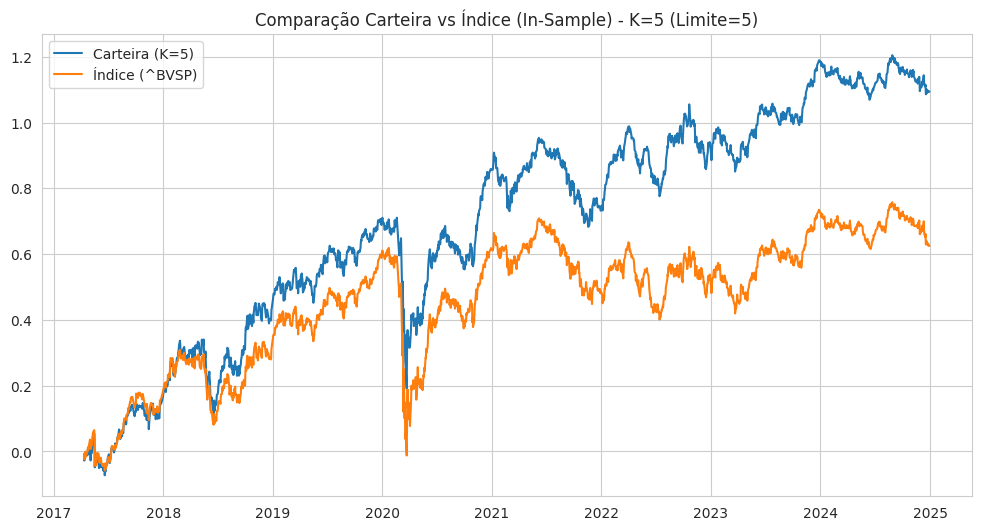

Tracking Error (In-Sample): 0.288841

--- ATIVOS SELECIONADOS NA CARTEIRA ---
Total de ativos selecionados (K): 5
|           |   Peso |
|:----------|-------:|
| ITUB4.SA  | 0.2671 |
| TAEE11.SA | 0.2043 |
| B3SA3.SA  | 0.1877 |
| VALE3.SA  | 0.1786 |
| PETR4.SA  | 0.1623 |


In [7]:
# @title IBOVESPA 1 (Corrigido: Erros de 'yfinance' e 'AttributeError')
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
import warnings

# Suprimir avisos
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

"""**2. Baixar os dados dos índice. Precisamos de 7 anos de histórico."""
# Definir datas
start_date = "2017-01-01"
end_date = "2024-12-31"
# Índices
ibov = "^BVSP"
# Baixar os preços de fechamento ajustados
dados_ibov = yf.download(ibov, start=start_date, end=end_date)["Close"]

"""3. Baixar os componentes do IBOV"""
tickers_ibov = [
    # Financeiro
    "ITUB4.SA", "B3SA3.SA", "BBAS3.SA", "BPAC11.SA", "CIEL3.SA", "SANB11.SA",
    "BBDC4.SA", "XPBR31.SA", "ASAI3.SA",
    # Materiais Básicos
    "VALE3.SA", "SUZB3.SA", "GGBR4.SA", "CSNA3.SA", "USIM5.SA", "CMIN3.SA",
    # Petróleo, Gás e Biocombustíveis
    "PETR4.SA", "PRIO3.SA", "RECV3.SA", "ENEV3.SA",
    # Utilidades Públicas
    "ELET3.SA", "ENBR3.SA", "TAEE11.SA", "CMIG4.SA", "TRPL4.SA",
    # Consumo Cíclico
    "LREN3.SA", "MGLU3.SA", "CVCB3.SA", "COGN3.SA", "RENT3.SA", "HYPE3.SA",
    "ALPA4.SA",
    # Bens Industriais
    "WEGE3.SA", "EMBR3.SA", "CCRO3.SA", "AZUL4.SA", "GOLL4.SA",
    # Saúde
    "HAPV3.SA", "QUAL3.SA", "RDOR3.SA",
    # Consumo Não Cíclico
    "ABEV3.SA", "JBSS3.SA", "BRFS3.SA", "RAIL3.SA",
    # Tecnologia da Informação
    "TOTVS3.SA",
    # Comunicações
    "VIVT3.SA",
    # Construção Civil
    "EZTC3.SA"
]

# Baixar dados de preços (dados_acoes)
dados_acoes = yf.download(tickers_ibov, start=start_date, end=end_date)["Close"]

""" ** 4. Tratar os dados** """

# CORREÇÃO (FALHAS YFINANCE): Remove colunas que falharam totalmente o download (só têm NaNs)
dados_acoes = dados_acoes.dropna(axis=1, how='all')

# Preenchimento de NaNs com o valor anterior
dados_acoes = dados_acoes.ffill()
dados_ibov = dados_ibov.ffill()
# Remover colunas com mais de 10% de valores nulos (Se existirem)
dados_acoes = dados_acoes.dropna(axis=1, thresh=int(0.9 * len(dados_acoes)))

""" **5. Calcular retornos (COM ALINHAMENTO CORRIGIDO)** """
# Retornos logarítmicos
retornos_brutos = np.log(dados_acoes / dados_acoes.shift(1))
retorno_indice_bruto = np.log(dados_ibov / dados_ibov.shift(1))

# ⭐️ CORREÇÃO (AttributeError): Garante que o retorno do índice é 1D
if isinstance(retorno_indice_bruto, pd.DataFrame):
    # Se for um DF (porque o slice ["Close"] falhou), seleciona a primeira coluna
    retorno_indice_bruto = retorno_indice_bruto.iloc[:, 0]

# Agora 'retorno_indice_bruto' é 100% uma Série, e .to_frame() funcionará
df_indice = retorno_indice_bruto.to_frame(name='Index')

# Usa .join() para fundir os dois DataFrames (how='inner' garante interseção de datas)
df_retornos_alinhados = retornos_brutos.join(df_indice, how='inner')

# Aplica o dropna() UMA VEZ no DataFrame unido
df_retornos_alinhados = df_retornos_alinhados.dropna(how='any')

# Separa as variáveis finais, agora perfeitamente alinhadas
retornos = df_retornos_alinhados.drop(columns=['Index'])
retorno_indice = df_retornos_alinhados['Index']


print(f"\nTotal de ativos após tratamento: {retornos.shape[1]}")
print(f"Total de períodos (dias de negociação): {retornos.shape[0]}")


# ⭐️ PARÂMETRO CHAVE: K Máximo
[cite_start]K_MAXIMO = 5 # Definindo o limite máximo de ativos [cite: 26]

# ====================================================================
# ⭐️ Define n e T lendo do DataFrame 'retornos'
# ====================================================================
try:
    n = retornos.shape[1]
    [cite_start]T = retornos.shape[0] [cite: 20]
    print(f"Script de otimização lendo n={n} ativos e T={T} períodos.")
except NameError:
    print("❌ ERRO: O DataFrame 'retornos' não foi encontrado.")
    print("Por favor, rode a célula de carregamento de dados ANTES desta.")
    raise

# ====================================================================
# 1. PREPARAÇÃO DE DADOS PARA GUROBI
# ====================================================================

# Calcule a Matriz de Covariância
Retornos_DF = retornos.copy()
Retornos_DF['Index'] = retorno_indice
Matriz_Cov = Retornos_DF.cov() * T

Cov_Acoes = Matriz_Cov.iloc[:-1, :-1].values # Matriz N x N
Cov_Index = Matriz_Cov.iloc[-1, :-1].values  # Vetor 1 x N
Var_Index = Matriz_Cov.iloc[-1, -1]          # Escalar

# Constante Big M
BIG_M = 1.0 # O peso máximo de um ativo, já que sum(w) = 1

# ====================================================================
# 2. MODELAGEM GUROBI DIRETA (K Fixo)
# ====================================================================

modelo = gp.Model("Index_Tracking_MIQP_K_Fixo")

# [cite_start]Variáveis (w: contínua >= 0; z: binária) [cite: 21, 22]
w_gurobi = modelo.addVars(n, name="w", lb=0.0)
[cite_start]z_gurobi = modelo.addVars(n, name="z", vtype=gp.GRB.BINARY) [cite: 18]

# Restrições
# [cite_start]1. Soma dos pesos = 1 [cite: 13]
modelo.addConstr(w_gurobi.sum() == 1, name="Soma_Pesos")

# [cite_start]2. Restrição K (<= 5) [cite: 18]
modelo.addConstr(z_gurobi.sum() <= K_MAXIMO, name="Restricao_K_Max")

# [cite_start]3. Vínculo Binário (w_i <= M * z_i) [cite: 15]
modelo.addConstrs((w_gurobi[i] <= BIG_M * z_gurobi[i] for i in range(n)), name="Vinculo_Binario")

# (Restrição w_i >= 0 já definida em lb=0.0) [cite_start][cite: 14]

# [cite_start]Função Objetivo (Minimizar a Variância do Tracking Error) [cite: 12]
termo_quadratico = gp.QuadExpr()
for i in range(n):
    for j in range(n):
        termo_quadratico.addTerms(Cov_Acoes[i, j], w_gurobi[i], w_gurobi[j])

termo_linear = gp.LinExpr()
for i in range(n):
    termo_linear.addTerms(-2 * Cov_Index[i], w_gurobi[i])

modelo.setObjective(termo_quadratico + termo_linear + Var_Index, gp.GRB.MINIMIZE)

# [cite_start]3. Otimizar [cite: 43]
modelo.Params.MIPGap = 0.05
modelo.Params.TimeLimit = 600
modelo.Params.OutputFlag = 1
print(f"\nIniciando otimização direta com Gurobi (MIQP, K <= {K_MAXIMO})...")
modelo.optimize()

# ====================================================================
# [cite_start]4. TRATAMENTO DE RESULTADOS [cite: 44]
# ====================================================================
pesos = np.zeros(n)
k_selecionado = 0

if modelo.status == gp.GRB.OPTIMAL or (modelo.status == gp.GRB.TIME_LIMIT and modelo.SolCount > 0):
    if modelo.status == gp.GRB.OPTIMAL:
        print("✅ Otimização Direta com Gurobi concluída com sucesso!")
    else:
        print("✅ Otimização finalizada por limite de tempo. Usando melhor solução encontrada.")

    pesos = np.array([w_gurobi[i].X for i in range(n)])
    k_selecionado = np.sum(pesos > 1e-4)

elif modelo.status == gp.GRB.INFEASIBLE:
    print("❌ Otimização Falhou: Modelo Inviável.")
else:
    print(f"❌ Otimização Falhou. Status Gurobi: {modelo.status}")


""" **7. Validar a carteira (In-Sample)** """
# Otimização funcionou: prosseguir com a validação
carteira = (retornos @ pesos).cumsum()
indice = retorno_indice.cumsum()

plt.figure(figsize=(12, 6))
plt.plot(carteira, label=f"Carteira (K={k_selecionado})")
plt.plot(indice, label="Índice (^BVSP)")
plt.legend()
plt.title(f"Comparação Carteira vs Índice (In-Sample) - K={k_selecionado} (Limite={K_MAXIMO})")
plt.show()

# Tracking Error In-Sample
te_in_sample = np.sqrt(np.mean((carteira.values - indice.values)**2))
print(f"Tracking Error (In-Sample): {te_in_sample:.6f}")


# Exibir ativos selecionados
pesos_df = pd.DataFrame(
    {'Peso': pesos},
    index=retornos.columns
)
ativos_selecionados = pesos_df[pesos_df['Peso'] > 1e-4]
ativos_selecionados = ativos_selecionados.sort_values(by='Peso', ascending=False)

print("\n--- ATIVOS SELECIONADOS NA CARTEIRA ---")
print(f"Total de ativos selecionados (K): {len(ativos_selecionados)}")
print(ativos_selecionados.to_markdown(floatfmt=".4f"))

[*********************100%***********************]  1 of 1 completed
[***                    7%                       ]  3 of 46 completed

⬇️  Baixando dados do índice e componentes...


[*********************100%***********************]  46 of 46 completed
ERROR:yfinance:
7 Failed downloads:
ERROR:yfinance:['TOTVS3.SA', 'CIEL3.SA', 'ENBR3.SA', 'GOLL4.SA', 'TRPL4.SA', 'JBSS3.SA', 'CCRO3.SA']: YFTzMissingError('possibly delisted; no timezone found')


✅ Dados carregados: 808 dias, 39 ativos.

🧩 Total de dias disponíveis: 808
📘 Usando 3 dias para treino e 161 dias para teste.
📊 Iniciando backtesting com janela deslizante...


➡️  Fold 1: Teste 2021-10-08 a 2022-06-02

📊 Ações escolhidas pelo modelo (K=3):
|           | Peso (%)   |
|:----------|:-----------|
| BBAS3.SA  | 41.26 %    |
| XPBR31.SA | 34.06 %    |
| RAIL3.SA  | 24.68 %    |
   Status Gurobi: Optimal


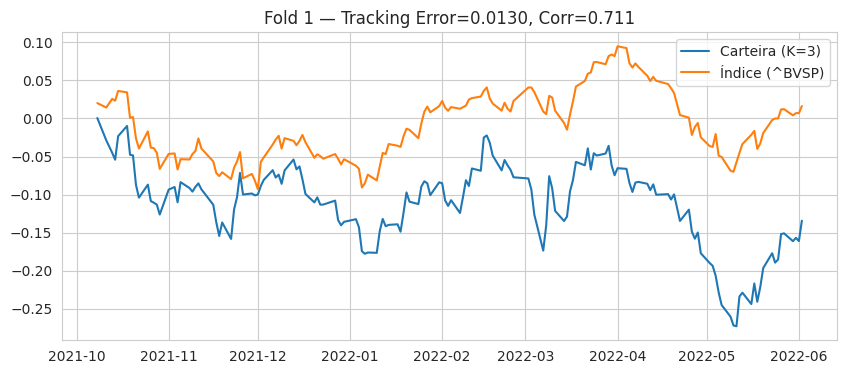


➡️  Fold 2: Teste 2022-06-03 a 2023-01-23

📊 Ações escolhidas pelo modelo (K=3):
|           | Peso (%)   |
|:----------|:-----------|
| BRFS3.SA  | 42.80 %    |
| HYPE3.SA  | 29.43 %    |
| XPBR31.SA | 27.77 %    |
   Status Gurobi: Optimal


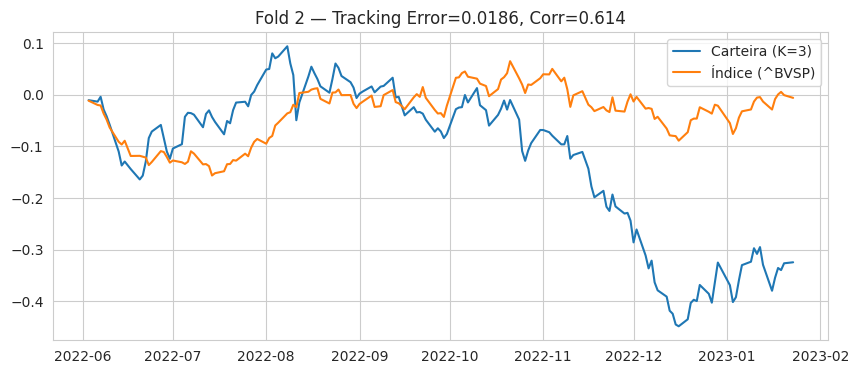


➡️  Fold 3: Teste 2023-01-24 a 2023-09-14

📊 Ações escolhidas pelo modelo (K=3):
|          | Peso (%)   |
|:---------|:-----------|
| BRFS3.SA | 56.88 %    |
| RDOR3.SA | 36.74 %    |
| VIVT3.SA | 6.38 %     |
   Status Gurobi: Optimal


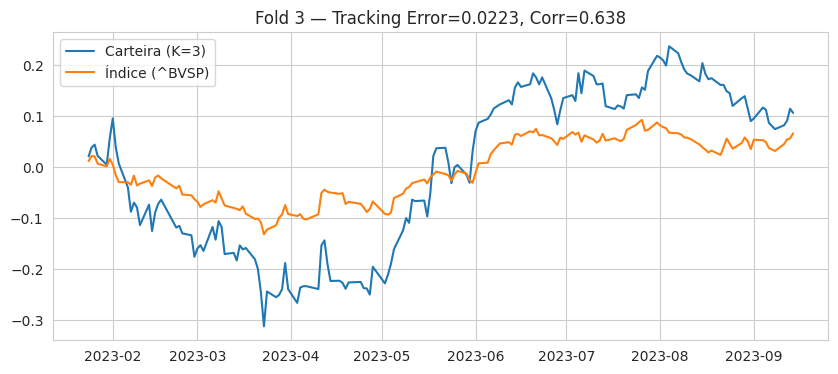


➡️  Fold 4: Teste 2023-09-15 a 2024-05-10

📊 Ações escolhidas pelo modelo (K=3):
|          | Peso (%)   |
|:---------|:-----------|
| CMIN3.SA | 55.79 %    |
| ASAI3.SA | 34.74 %    |
| WEGE3.SA | 9.47 %     |
   Status Gurobi: Optimal


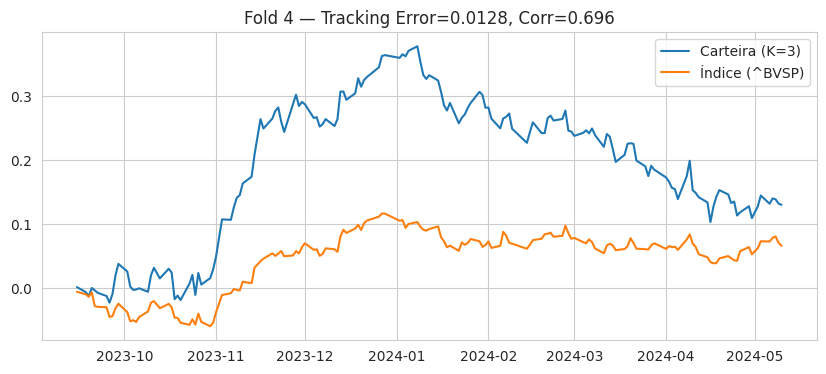


➡️  Fold 5: Teste 2024-05-13 a 2024-12-30

📊 Ações escolhidas pelo modelo (K=3):
|          | Peso (%)   |
|:---------|:-----------|
| BBAS3.SA | 38.01 %    |
| VIVT3.SA | 34.56 %    |
| MGLU3.SA | 27.44 %    |
   Status Gurobi: Optimal


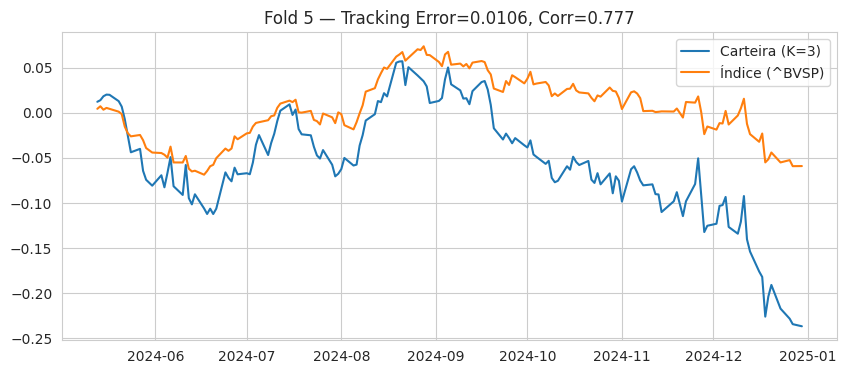


📈 Resultados finais:
|   Fold |   TrackingError |   Correlação |
|-------:|----------------:|-------------:|
| 1.0000 |          0.0130 |       0.7112 |
| 2.0000 |          0.0186 |       0.6140 |
| 3.0000 |          0.0223 |       0.6380 |
| 4.0000 |          0.0128 |       0.6963 |
| 5.0000 |          0.0106 |       0.7775 |

📉 Média TE: 0.015466 | Média Corr: 0.6874


In [15]:
# @title IBOVESPA 2 (Corrigido para 5 Folds)
# -*- coding: utf-8 -*-
"""Index Tracking com MIQP (Gurobi) — Backtesting com ajuste automático de janelas"""

# ============================================================
# 1. Importações e Configuração Inicial
# ============================================================
%matplotlib inline
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gurobipy as gp
import os
import warnings

# Suprimir avisos
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

sns.set_style("whitegrid")

# ============================================================
# 2. Parâmetros Gerais
# ============================================================
K_ATUAL = 5  # número MÁXIMO de ativos
start_date = "2017-01-01"
end_date = "2024-12-31"
index_symbol = "^BVSP" #IBOVESPA
BIG_M = 1.0 # Constante para vínculo binário

# ============================================================
# 3. Baixar Dados (CORRIGIDO)
# ============================================================
print("⬇️  Baixando dados do índice e componentes...")

# ⭐️ CORREÇÃO 1: Usando a lista completa de tickers do IBOVESPA
tickers_ibov = [
    # Financeiro
    "ITUB4.SA", "B3SA3.SA", "BBAS3.SA", "BPAC11.SA", "CIEL3.SA", "SANB11.SA",
    "BBDC4.SA", "XPBR31.SA", "ASAI3.SA",
    # Materiais Básicos
    "VALE3.SA", "SUZB3.SA", "GGBR4.SA", "CSNA3.SA", "USIM5.SA", "CMIN3.SA",
    # Petróleo, Gás e Biocombustíveis
    "PETR4.SA", "PRIO3.SA", "RECV3.SA", "ENEV3.SA",
    # Utilidades Públicas
    "ELET3.SA", "ENBR3.SA", "TAEE11.SA", "CMIG4.SA", "TRPL4.SA",
    # Consumo Cíclico
    "LREN3.SA", "MGLU3.SA", "CVCB3.SA", "COGN3.SA", "RENT3.SA", "HYPE3.SA",
    "ALPA4.SA",
    # Bens Industriais
    "WEGE3.SA", "EMBR3.SA", "CCRO3.SA", "AZUL4.SA", "GOLL4.SA",
    # Saúde
    "HAPV3.SA", "QUAL3.SA", "RDOR3.SA",
    # Consumo Não Cíclico
    "ABEV3.SA", "JBSS3.SA", "BRFS3.SA", "RAIL3.SA",
    # Tecnologia da Informação
    "TOTVS3.SA",
    # Comunicações
    "VIVT3.SA",
    # Construção Civil
    "EZTC3.SA"
]

# Baixar os preços de fechamento ajustados
dados_indice = yf.download(index_symbol, start=start_date, end=end_date)["Close"]
dados_acoes = yf.download(tickers_ibov, start=start_date, end=end_date)["Close"]

# Tratamento de dados
dados_acoes = dados_acoes.dropna(axis=1, how='all')
dados_indice = dados_indice.ffill().dropna(axis=0)
dados_acoes = dados_acoes.ffill().dropna(axis=0)
dados_acoes = dados_acoes.dropna(axis=1, thresh=int(0.9 * len(dados_acoes)))

# ============================================================
# 4. Calcular Retornos (CORRIGIDO)
# ============================================================
# ⭐️ CORREÇÃO 2: Alinhamento Robusto de Datas

retornos_brutos = np.log(dados_acoes / dados_acoes.shift(1))
retorno_indice_bruto = np.log(dados_indice / dados_indice.shift(1))

# Garante que o índice é 1D
if isinstance(retorno_indice_bruto, pd.DataFrame):
    retorno_indice_bruto = retorno_indice_bruto.iloc[:, 0]

df_indice = retorno_indice_bruto.to_frame(name='Index')
df_retornos_alinhados = retornos_brutos.join(df_indice, how='inner')
df_retornos_alinhados = df_retornos_alinhados.dropna(how='any')

retornos = df_retornos_alinhados.drop(columns=['Index'])
retorno_indice = df_retornos_alinhados['Index']

print(f"✅ Dados carregados: {len(retornos)} dias, {retornos.shape[1]} ativos.\n")

# ============================================================
# 5. Função para resolver o MIQP direto com Gurobi (CORRIGIDO)
# ============================================================
def resolver_miqp_cov(Cov_Acoes, Cov_Index, Var_Index, n_ativos, K_ATUAL):
    model = gp.Model("IndexTrackingMIQP")
    model.Params.OutputFlag = 0
    model.Params.MIPGap = 0.05
    model.Params.TimeLimit = 120  # segundos por fold

    w = model.addVars(n_ativos, lb=0.0, name="w")
    z = model.addVars(n_ativos, vtype=gp.GRB.BINARY, name="z")

    model.addConstr(w.sum() == 1, name="Soma_Pesos")

    # ⭐️ CORREÇÃO 3: Usando K <= 5 (como no briefing)
    model.addConstr(z.sum() <= K_ATUAL, name="Restricao_K_Max")

    model.addConstrs((w[i] <= BIG_M * z[i] for i in range(n_ativos)), name="Vinculo_Binario")


    # Função Objetivo (QP)
    quad = gp.QuadExpr()
    for i in range(n_ativos):
        for j in range(n_ativos):
            quad.addTerms(Cov_Acoes[i, j], w[i], w[j])

    lin = gp.LinExpr()
    for i in range(n_ativos):
        lin.addTerms(-2 * Cov_Index[i], w[i])

    model.setObjective(quad + lin + Var_Index, gp.GRB.MINIMIZE)
    model.optimize()

    pesos = np.zeros(n_ativos)
    status = model.status

    if model.SolCount > 0 and (status == gp.GRB.OPTIMAL or status == gp.GRB.TIME_LIMIT):
        pesos = np.array([w[i].X for i in range(n_ativos)])

    return pesos, status

# ============================================================
# 6. Função de Backtesting (CORRIGIDO)
# ============================================================
def backtest_rolling_ibov(retornos, retorno_indice, K_ATUAL):
    n_total = len(retornos)
    n_ativos = retornos.shape[1]
    N_FOLDS_DESEJADOS = 5

    # ⭐️ CORREÇÃO PARA 5 FOLDS: Ajuste dinâmico das janelas
    # Define o teste como ~1 ano
    TEST_DAYS = min(252, int(n_total * 0.2))
    # Calcula o treino com o que sobrou, garantindo 5 folds de teste
    TRAIN_DAYS = n_total - (N_FOLDS_DESEJADOS * TEST_DAYS)

    if TRAIN_DAYS <= 0:
        print("❌ ERRO: Dados insuficientes para 5 folds de teste. Reduza N_FOLDS_DESEJADOS ou TEST_DAYS.")
        return

    print(f"🧩 Total de dias disponíveis: {n_total}")
    print(f"📘 Usando {TRAIN_DAYS} dias para treino e {TEST_DAYS} dias para teste.")
    print("📊 Iniciando backtesting com janela deslizante...\n")

    resultados = []
    start_train = 0
    fold = 1

    # Dicionário para traduzir o status do Gurobi
    status_map = {
        gp.GRB.OPTIMAL: "Optimal",
        gp.GRB.TIME_LIMIT: "Time Limit",
        gp.GRB.INFEASIBLE: "Infeasible",
        gp.GRB.UNBOUNDED: "Unbounded",
        gp.GRB.INF_OR_UNBD: "Infeasible or Unbounded"
    }

    # O loop agora irá parar exatamente após o 5º fold
    while start_train + TRAIN_DAYS + TEST_DAYS <= n_total:
        # Datas de treino e teste
        data_inicio_teste = retornos.index[start_train + TRAIN_DAYS].strftime('%Y-%m-%d')
        data_fim_teste = retornos.index[start_train + TRAIN_DAYS + TEST_DAYS - 1].strftime('%Y-%m-%d')
        print(f"\n➡️  Fold {fold}: Teste {data_inicio_teste} a {data_fim_teste}")

        # Fatiamento dos dados
        ret_treino = retornos.iloc[start_train:start_train + TRAIN_DAYS]
        ret_teste = retornos.iloc[start_train + TRAIN_DAYS:start_train + TRAIN_DAYS + TEST_DAYS]
        ind_treino = retorno_indice.iloc[start_train:start_train + TRAIN_DAYS]
        ind_teste = retorno_indice.iloc[start_train + TRAIN_DAYS:start_train + TRAIN_DAYS + TEST_DAYS]

        # Preparação da Covariância
        Retornos_DF = ret_treino.copy()
        Retornos_DF["Index"] = ind_treino.reindex(ret_treino.index)
        Cov = Retornos_DF.cov() * len(Retornos_DF)

        Cov_Acoes = Cov.iloc[:-1, :-1].values
        Cov_Index = Cov.iloc[-1, :-1].values
        Var_Index = Cov.iloc[-1, -1]

        # Resolução do MIQP
        pesos, status = resolver_miqp_cov(Cov_Acoes, Cov_Index, Var_Index, n_ativos, K_ATUAL)

        if np.sum(pesos) == 0:
            print("❌ Nenhuma solução viável encontrada neste fold. Pulando.")
            start_train += TEST_DAYS
            fold += 1
            continue

        # Exibir ações escolhidas e pesos
        selecao = pd.Series(pesos, index=retornos.columns)
        selecao = selecao[selecao > 1e-4].sort_values(ascending=False)
        selecao_percent = selecao * 100
        selecao_formatada = selecao_percent.map('{:,.2f} %'.format)

        print(f"\n📊 Ações escolhidas pelo modelo (K={len(selecao)}):")
        print(selecao_formatada.to_frame("Peso (%)").to_markdown())

        status_str = status_map.get(status, str(status))
        print(f"   Status Gurobi: {status_str}")


        # Cálculo de Métricas (TE/Corr)
        ret_carteira_diario = ret_teste @ pesos

        df_teste_alinhado = pd.DataFrame({
            'Carteira': ret_carteira_diario.squeeze(),
            'Indice': ind_teste.squeeze()
        })
        df_teste_alinhado = df_teste_alinhado.dropna(how='any')

        if df_teste_alinhado.empty:
            print("⚠️ Dados insuficientes para calcular métricas neste período de teste. Pulando.")
            start_train += TEST_DAYS
            fold += 1
            continue

        ret_carteira_teste_final = df_teste_alinhado['Carteira']
        ret_indice_teste_final = df_teste_alinhado['Indice']

        # Calcular métricas com dados DIÁRIOS limpos
        te = np.sqrt(np.mean((ret_carteira_teste_final.values - ret_indice_teste_final.values)**2))
        corr = np.corrcoef(ret_carteira_teste_final.values, ret_indice_teste_final.values)[0, 1]

        resultados.append((fold, te, corr))

        # Calcular retornos ACUMULADOS apenas para plotagem
        ret_carteira_acum = ret_carteira_teste_final.cumsum()
        ret_indice_acum = ret_indice_teste_final.cumsum()

        plt.figure(figsize=(10, 4))
        plt.plot(ret_carteira_acum, label=f"Carteira (K={len(selecao)})")
        plt.plot(ret_indice_acum, label=f"Índice ({index_symbol})")
        plt.title(f"Fold {fold} — Tracking Error={te:.4f}, Corr={corr:.3f}")
        plt.legend()
        plt.show()

        fold += 1
        start_train += TEST_DAYS # Avança a janela

    df = pd.DataFrame(resultados, columns=["Fold", "TrackingError", "Correlação"])
    print("\n📈 Resultados finais:")
    print(df.to_markdown(index=False, floatfmt=".4f"))
    print(f"\n📉 Média TE: {df['TrackingError'].mean():.6f} | "
          f"Média Corr: {df['Correlação'].mean():.4f}")
    return df


# ============================================================
# 7. Executar backtesting IBOV
# ============================================================
df_resultados_ibov = backtest_rolling_ibov(retornos, retorno_indice, K_ATUAL)